In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### Variable Descriptions Used in Dynamical Model

Variable|Description
:---|:---
V|Viral load per epithelial cell
H|Proportion of healthy cells
I|Proportion of infected cells 
M|Activated antigen presenting cells per homeostatic level
F|Interferons per homeostatic level of macrophages
R|Proportion of resistant cells
E|Effector cells per homeostatic level 
P|Plasma cells per homeostatic level
A|Antibodies per homeostatic level 
S|Antigenic distance

<br />

### Parameter Descriptions and Values for Differential Equations

Parameter|Value|Description
:---|:---:|:---
$\gamma_{V}$|510|Rate constant of influenza A virus (IAV) particles secretion per infected epithelial cells
$\gamma_{VA}$|619.2|Rate constant of neutralization of IAV by antibodies
$\gamma_{VH}$|1.02|Rate constant of adsorption of IAV by infected epithelial cells
$alpha_{V}$|1.7|Rate constant of nonspecific IAV removal
$a_{V1}$|100|Rate constant of nonspecific IAV removal
$a_{V2}$|23000|Rate constant of nonspecific IAV removal
$b_{HD}$|4|Rate constant of regeneration of epithelial cells
$a_{R}$|1|Rate constant of epithelial cells’ virus resistance state decay
$\gamma_{HV}$|0.34|Rate constant of epithelial cells infected by IAV
$b_{HF}$|0.01|Rate constant of epithelial cells’ virus resistant state induction
$b_{IE}$|0.066|Rate constant of infected epithelial cells that CTL damage
$a_{I}$|1.5|Rate constant of infected epithelial cells damage by cytopathicity of IAV
$b_{MD}$|1|Rate constant of stimulation of antigen presenting cells by dead cells
$b_{MV}$|0.0037|Rate constant of stimulation of antigen presenting cells by virus particles
$a_{M}$|1|Rate constant of stimulated state loss of antigen presenting cells
$b_{F}$|250000|Interferon (IFN) production rate per APC
$c_{F}$|2000|Interferon (IFN) production rate per infected cell
$b_{FH}$|17|Rate constant of epithelial cells that IFN binds
$a_{F}$|8|Rate constant of IFN’s natural decay
$b_{EM}$|8.8|Rate constant of stimulation of effector cells
$b_{EI}$|2.72|Rate constant of death of effectors by lytic interactions with infected epithelial cells
$a_{E}$|0.4|Rate constant of natural death of effector cells
$b_{PM}$|11.5|Rate constant of plasma cells production
$a_{P}$|0.4|Rate constant of natural death of plasma cells
$b_{A}$|0.043|Antibody production rate per plasma cells 
$\gamma_{AV}$|146.2|Rate constant of antibodies which binds to IAV
$a_{A}$|0.043|Rate constant of natural death of antibodies
$r$|3e-5|Rate constant for S variable

In [11]:
# Define system of equations
def get_deriv(state, t, params):
    '''
    Computes the derivatives of a dynamical model of human immune response to influenza A virus infection.

    Parameters:
        state (array_like): An array-like object of length 10 representing the state of the system at time t.

        t (float): The current time point

        params (list): A list containing the values of parameters in the system of differential equations.

    Returns:
        array_like: An array of length 10 representing the derivatives of the state variables with respect to time.
            The elements of the array correspond to the elements of the state array in the same order.
    '''
    
    # Unpack parameters
    gammaV, gammaVA, gammaVH, alphaV, aV1, aV2, bHD, aR, gammaHV, bHF, bIE, aI, bMD, bMV, aM, bF, cF, bFH, aF, bEM, bEI, aE, bPM, aP, bA, gammaAV, aA, r = params
    
    # Unpack state variables
    V, H, I, M, F, R, E, P, A, S = state

    # Define proportion of dead cells
    D = 1 - H - R - I

    # Define differential equations
    dVdt = (gammaV * I) - (gammaVA * S * A * V) - (gammaVH * H * V) - (alphaV * V) - ((aV1 * V)/(1 + (aV2 * V)))
    dHdt = ((bHD * D) * (H + R)) + (aR * R) - (gammaHV * V * H) - (bHF * F * H)
    dIdt = (gammaHV * V * H) - (bIE * E * I) - (aI * I)
    dMdt = (((bMD * D) + (bMV * V)) * (1 - M)) - (aM * M)
    dFdt = (bF * M) + (cF * I) - (bFH * H * F) - (aF * F)
    dRdt = (bHF * F * H) - (aR * R)
    dEdt = (bEM * M * E) - (bEI * I * E) + (aE * (1 - E))
    dPdt = (bPM * M * P) + (aP * (1 - P))
    dAdt = (bA * P) - (gammaAV * S * A * V) - (aA * A)
    dSdt = (r * P) * (1 - S)

    # Return an array containing the derivative of each variable
    return np.array([dVdt, dHdt, dIdt, dMdt, dFdt, dRdt, dEdt, dPdt, dAdt, dSdt])


In [12]:
# Define standard parameters
gammaV = 510
gammaVA = 619.2
gammaVH = 1.02
alphaV = 1.7
aV1 = 100
aV2 = 23000
bHD = 4
aR = 1
gammaHV = 0.34
bHF = 0.01
bIE = 0.066
aI = 1.5
bMD = 1
bMV = 0.0037
aM = 1
bF = 250000
cF = 2000
bFH = 17
aF = 8
bEM = 8.8
bEI = 2.72
aE = 0.4
bPM = 11.5
aP = 0.4
bA = 0.043
gammaAV = 146.2
aA = 0.043
r = 3e-5

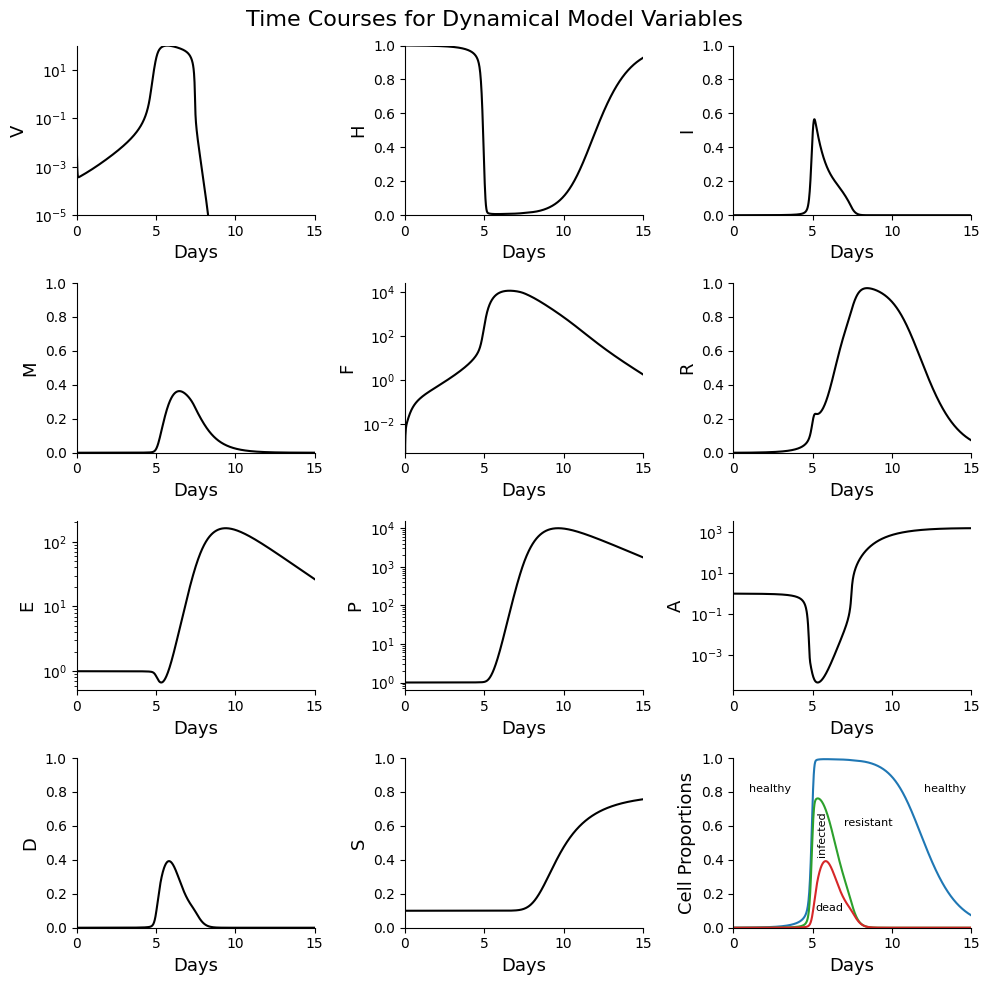

In [82]:
# Figure 1

# -------------- Time courses --------------

# Generate time array that contains 1000 equally-spaced values between 0 and 15
t = np.linspace(0, 15, 1000)

# Define parameters under standard conditions
params_std = [gammaV, gammaVA, gammaVH, alphaV, aV1, aV2, bHD, aR, gammaHV, bHF, bIE, aI, bMD, bMV, aM, bF, cF, bFH, aF, bEM, bEI, aE, bPM, aP, bA, gammaAV, aA, r]

# Define initial values for standard behavior
V0, H0, I0, M0, F0, R0, E0, P0, A0, S0 = 0.01, 1, 0, 0, 0, 0, 1, 1, 1, 0.1

# Initial state of the system with standard values
state0 = [V0, H0, I0, M0, F0, R0, E0, P0, A0, S0]

# Integrate the system of differential equations over time t
state = odeint(get_deriv, state0, t, args=(params_std,))

# Transpose state matrix to get individual time series for each variable
V, H, I, M, F, R, E, P, A, S = state.T

# Define proportion of dead cells
D = 1 - H - R - I

# Initialize subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(5, 10))
fig.set_figwidth(10)
fig.suptitle('Time Courses for Dynamical Model Variables', fontsize = 16)
fig.subplots_adjust(top=0.94)

# Initialize values and labels
F1_labels = ['V', 'H', 'I', 'M', 'F', 'R', 'E', 'P', 'A', 'D', 'S', 'Cell Proportions']
F1_vals = [V, H, I, M, F, R, E, P, A, D, S]

# Iterate through subplots, plotting each timecourse
for i, ax in enumerate(axes.flat):
    ax.set_xlim(0, 15)
    ax.set_xlabel('Days', fontsize=13)
    ax.set_ylabel(F1_labels[i], fontsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i in [0]:
        ax.semilogy(t, F1_vals[i], color = 'k')
        ax.set_ylim(10**-5, 10**2)

    if i in [1, 2, 3, 5, 9, 10]:
        ax.plot(t, F1_vals[i], color = 'k')
        ax.set_ylim(0, 1.0)

    if i in [4, 6, 7, 8]:
        ax.semilogy(t, F1_vals[i], color = 'k')

    if i in [11]:
        ax.plot(t, np.max(H) - H, color = '#1f77b4')
        ax.plot(t, I+D, color = '#2ca02c')
        ax.plot(t, D, color = '#d62728')
        ax.text(5.2, 0.1, 'dead', fontsize=8)
        ax.text(5.3, 0.43, 'infected', fontsize=8, rotation=90)
        ax.text(7, 0.6, 'resistant', fontsize=8)
        ax.text(12, 0.8, 'healthy', fontsize=8)
        ax.text(1, 0.8, 'healthy', fontsize=8)
        ax.set_ylim(0, 1.0)

# Set layout, save figure, and show plots
fig.tight_layout()
plt.savefig('figure1', dpi = 300)
plt.show()

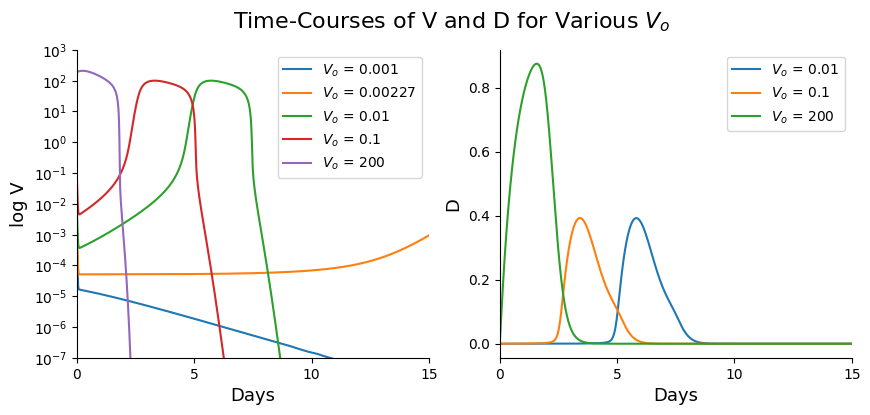

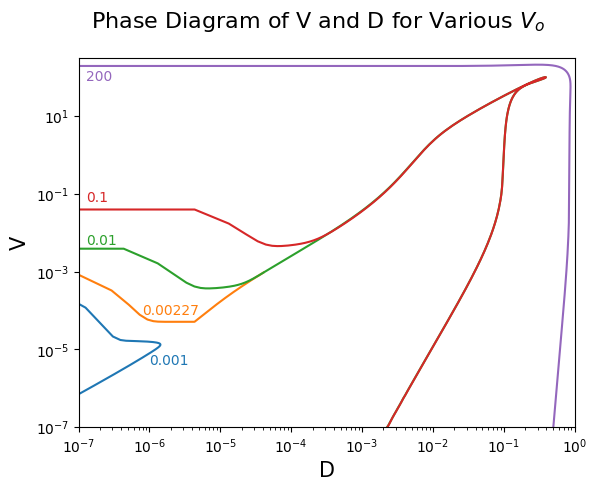

In [65]:
# Figure 2

# -------------- Time courses --------------

# List various values for initial viral load
V0_lst = [0.001, 0.00227, 0.01, 0.1, 200]

# Create empty lists to store results
V_VL, D_VL = [], []

# Loop through each value of initial viral load
for i in range(len(V0_lst)):
    
    # Define initial state with current viral load value
    state0 = [V0_lst[i], H0, I0, M0, F0, R0, E0, P0, A0, S0]
    
    # Solve ODEs using revised initial state and standard parameters
    state = odeint(get_deriv, state0, t, args=(params_std,))
    
    # Extract the results for V, H, I, and R
    V = state[:, 0]
    H = state[:, 1]
    I = state[:, 2]
    R = state[:, 5]

    # Calculate the results for the proportion of dead cells
    D = 1 - H - R - I
    
    # Append results to respective lists
    V_VL.append(V), D_VL.append(D)


# Initialize y axis labels and subplots
F2_labels = ['log V', 'D']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle(r'Time-Courses of V and D for Various $V_o$', fontsize = 16)

# Set plot parameters and labels for each subplot
for i, ax in enumerate(axes.flat):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i in range(0, 2):
        xticks = np.arange(0, 16, 5)
        ax.set_xticks(xticks)
        ax.set_xlim(0, 15)
        ax.set_xlabel('Days', fontsize=13)
        ax.set_ylabel(F2_labels[i], fontsize=13)

# Plot time course of V for various initial viral loads
for i in range(len(V0_lst)):
    axes[0].semilogy(t, V_VL[i], label=r'$V_o$ = {}'.format(V0_lst[i]))
yticks = [10**i for i in range(-7, 4)]
axes[0].set_ylim([yticks[0], yticks[-1]])
axes[0].set_yticks(yticks)
axes[0].legend()

# Plot time course of D for various initial vivral loads
for i in range(2, len(V0_lst)):
    axes[1].plot(t, D_VL[i], label=r'$V_o$ = {}'.format(V0_lst[i]))
axes[1].legend()

# Save figure and show time courses
plt.savefig('figure2A', dpi = 300)
plt.show()

# -------------- Phase diagram --------------

# Initialize the phase diagram
fig, ax = plt.subplots()
fig.suptitle(r'Phase Diagram of V and D for Various $V_o$', fontsize = 16)

# Plot trajectories for different initial conditions
for i in range(len(V0_lst)):
    ax.plot(D_VL[i], V_VL[i])

# Set labels and scales for the axes
ax.set_xlabel('D', fontsize=15)
ax.set_ylabel('V', fontsize=15)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**-7, 10**0])
ax.set_ylim([10**-7, 10**2.5])

# Set annotations for each value of V0
ax.text(10**-6.9, 10**1.9, '200', fontsize=10, color = '#9467bd')
ax.text(10**-6.9, 10**-1.2, '0.1', fontsize=10, color = '#d62728')
ax.text(10**-6.9, 10**-2.3, '0.01', fontsize=10, color = '#2ca02c')
ax.text(10**-6.1, 10**-4.1, '0.00227', fontsize=10, color = '#ff7f0e')
ax.text(10**-6, 10**-5.4, '0.001', fontsize=10, color = '#1f77b4')


# Add legend, save figure, and show phase diagram
# ax.legend(loc = 'upper left', fontsize=8)
plt.savefig('figure2B', dpi = 300)
plt.show()

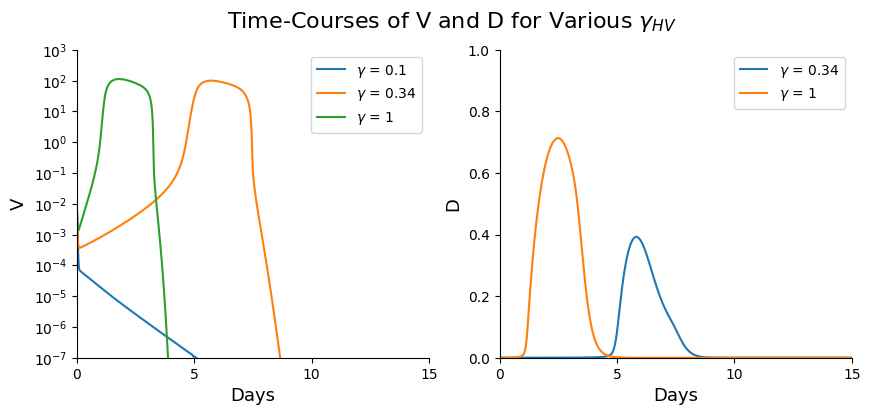

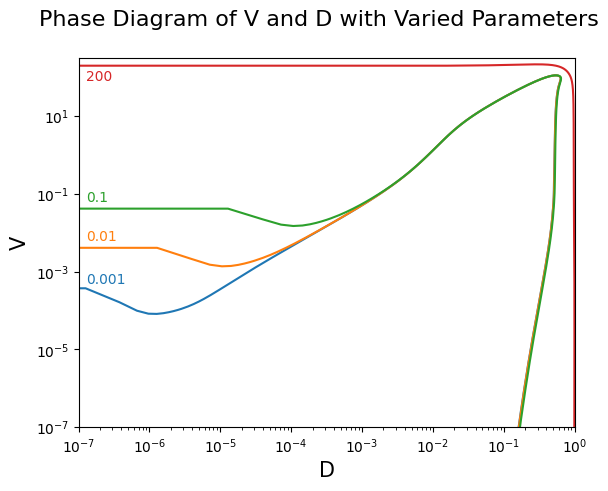

In [77]:
# Figure 3

# -------------- Time courses --------------

# List various values for gamma_HV
gammaHV_lst = [0.1, 0.34, 1]

# Create empty lists to store results
V_gammaHV, D_gammaHV = [], []

# Loop through each value of gammaHV
for i in range(len(gammaHV_lst)):

    # Set parameters for each gammaHV
    params_gammaHV = [gammaV, gammaVA, gammaVH, alphaV, aV1, aV2, bHD, aR, gammaHV_lst[i], bHF, bIE, aI, bMD, bMV, aM, bF, cF, bFH, aF, bEM, bEI, aE, bPM, aP, bA, gammaAV, aA, r]
    
    # Initial state of the system with standard values
    state0 = [V0, H0, I0, M0, F0, R0, E0, P0, A0, S0]

    # Solve ODEs using initial state and revised parameters
    state = odeint(get_deriv, state0, t, args = (params_gammaHV,))

    # Extract the results for V, H, I, and R
    V = state[:, 0]
    H = state[:, 1]
    I = state[:, 2]
    R = state[:, 5]

    # Calculate the results for the proportion of dead cells
    D = 1 - H - R - I

    # Append results to respective lists
    V_gammaHV.append(V), D_gammaHV.append(D)

# Initialize y axis labels, title, and subplots
F4_labels = ['V', 'D']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle(r'Time-Courses of V and D for Various $\gamma_{HV}$', fontsize = 16)

# Set plot parameters and labels for each subplot
for i, ax in enumerate(axes.flat):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if i in range(0, 2):
        xticks = np.arange(0, 16, 5)
        ax.set_xticks(xticks)
        ax.set_xlim(0, 15)
        ax.set_xlabel('Days', fontsize=13)
        ax.set_ylabel(F4_labels[i], fontsize=13)

# Plot time course of V for each gammaHV value
for i in range(len(gammaHV_lst)):  
    axes[0].semilogy(t, V_gammaHV[i], label=r'$\gamma$ = {}'.format(gammaHV_lst[i]))
yticks = [10**i for i in range(-7, 4)]
axes[0].set_ylim([yticks[0], yticks[-1]])
axes[0].set_yticks(yticks)
axes[0].legend()

# Plot time course of D for each gammaHV value
for i in range(1, len(gammaHV_lst)):
    axes[1].plot(t, D_gammaHV[i], label=r'$\gamma$ = {}'.format(gammaHV_lst[i]))
axes[1].set_ylim(0, 1.0)
axes[1].legend()

# Save figure and show time courses
plt.savefig('figure3A', dpi = 300)
plt.show()

# -------------- Phase diagram --------------

# Redefine parameters for sensitivity analysis
gammaHV_SA = 1
gammaV_SA = 510
gammaVA_SA = 619.2
bMD_SA = 2
bIE_SA = 0.066
aI_SA = 1.5
bHD_SA = 4
bF_SA = 250000
bA_SA = 0.043
bHF_SA = 0.02
bEM_SA = 8.3
bPM_SA = 11.3

# List various values for initial viral load
V0_SA = [0.001, 0.01, 0.1, 200]

# Create empty lists to store results
V_SA, D_SA = [], []

# Loop through length of V0_SA list
for i in range(len(V0_SA)):

    # Set parameters for sensitivity analysis
    params_SA = [gammaV_SA, gammaVA_SA, gammaVH, alphaV, aV1, aV2, bHD_SA, aR, gammaHV_SA, bHF, bIE_SA, aI_SA, bMD_SA, bMV, aM, bF_SA, cF, bFH, aF, bEM_SA, bEI, aE, bPM_SA, aP, bA_SA, gammaAV, aA, r]
    
    # Define initial state with current initial viral load
    state0 = [V0_SA[i], H0, I0, M0, F0, R0, E0, P0, A0, S0]
    
    # Solve ODEs using initial state and revised parameters
    state = odeint(get_deriv, state0, t, args=(params_SA,))

    # Extract the results for V, H, I, and R
    V = state[:, 0]
    H = state[:, 1]
    I = state[:, 2]
    R = state[:, 5]

    # Calculate the results for the proportion of dead cells
    D = 1 - H - R - I

    # Append results to respective lists
    V_SA.append(V), D_SA.append(D)

# Initialize the phase diagram
fig, ax = plt.subplots()
fig.suptitle('Phase Diagram of V and D with Varied Parameters', fontsize = 16)

# Plot trajectories for different initial conditions
for i in range(len(V0_SA)):
    ax.plot(D_SA[i], V_SA[i])

# Set labels and scales for the axes
ax.set_xlabel('D', fontsize=15)
ax.set_ylabel('V', fontsize=15)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**-7, 10**0])
ax.set_ylim([10**-7, 10**2.5])

# Set annotations for each value of V0
ax.text(10**-6.9, 10**1.9, '200', fontsize=10, color = '#d62728')
ax.text(10**-6.9, 10**-1.2, '0.1', fontsize=10, color = '#2ca02c')
ax.text(10**-6.9, 10**-2.2, '0.01', fontsize=10, color = '#ff7f0e')
ax.text(10**-6.9, 10**-3.3, '0.001', fontsize=10, color = '#1f77b4')

# Save figure, and show phase diagram
plt.savefig('figure3B', dpi = 300)
plt.show()


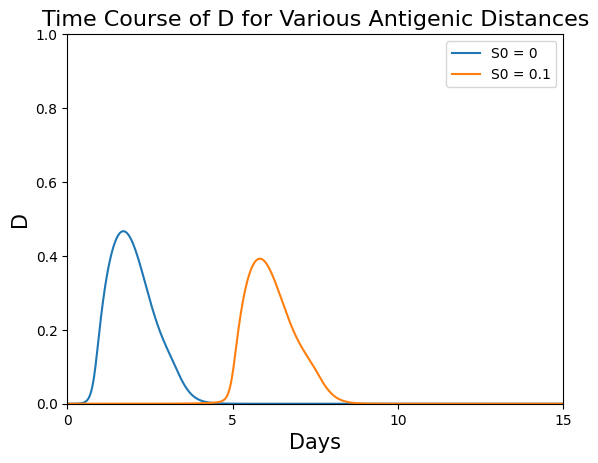

In [7]:
# Figure 4

# -------------- Time course --------------

# List various values for initial antigenic distance
S0_lst = [0, 0.1]

# Create empty lists to store results
V_AD, D_AD = [], []

# Loop through each value of initial antigenic distances
for i in range(len(S0_lst)):

    # Define initial state with current antigenic distance value
    state0 = [V0, H0, I0, M0, F0, R0, E0, P0, A0, S0_lst[i]]

    # Solve ODEs using revised initial state and standard parameters 
    state = odeint(get_deriv, state0, t, args=(params_std,))

    # Extract the results for V, H, I, and R
    V = state[:, 0]
    H = state[:, 1]
    I = state[:, 2]
    R = state[:, 5]

    # Calculate the results for the proportion of dead cells
    D = 1 - H - R - I

    # Append results to respective lists
    V_AD.append(V), D_AD.append(D)

# Plot trajectories for different initial conditions
for i in range(len(S0_lst)):
    plt.plot(t, D_AD[i], label='S0 = {}'.format(S0_lst[i]))

# Set title and labels/scales for the axes
plt.title('Time Course of D for Various Antigenic Distances', fontsize = 16)
plt.xlabel('Days', fontsize=15)
plt.ylabel('D', fontsize=15)
xticks = np.arange(0, 16, 5)
plt.xticks(xticks)
plt.xlim(0, 15)
plt.ylim(0, 1.0)

# Add legend, save figure, and show time course
plt.legend()
plt.savefig('figure4', dpi = 300)
plt.show()


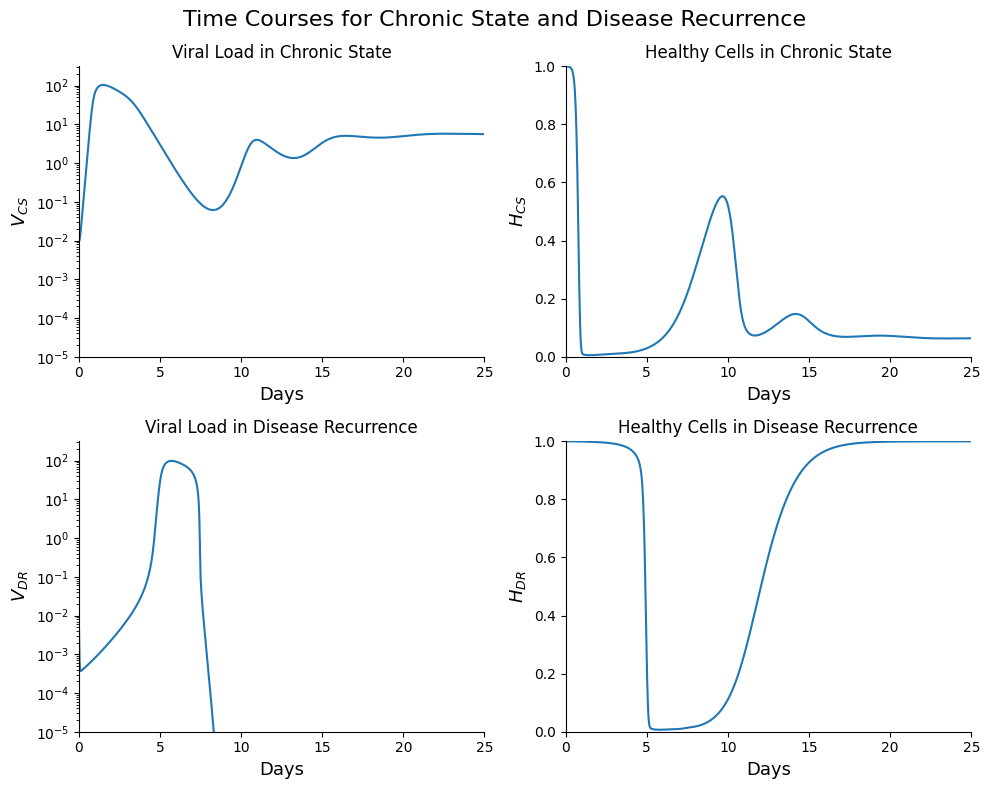

In [8]:
# Figure 5

# -------------- Time courses --------------

# Generate time array that contains 1000 equally-spaced values between 0 and 25
t = np.linspace(0, 25, 1000)

# Redefine r value for chronic state
r_CS = 0

# Define parameters with chronic state r value
params_CS = [gammaV, gammaVA, gammaVH, alphaV, aV1, aV2, bHD, aR, gammaHV, bHF, bIE, aI, bMD, bMV, aM, bF, cF, bFH, aF, bEM, bEI, aE, bPM, aP, bA, gammaAV, aA, r_CS]

# Define initial state with antigenic distance set to 0
state0 = [V0, H0, I0, M0, F0, R0, E0, P0, A0, 0]

# Solve ODEs using revised initial state and revised parameters 
state = odeint(get_deriv, state0, t, args=(params_CS,))

# Transpose state matrix to get individual time series for each variable
V_CS, H_CS, I_CS, M_CS, F_CS, R_CS, E_CS, P_CS, A_CS, S_CS = state.T

# Redefine r value for disease recurrence
r_DR = 10**-5

# Define parameters with disease recurrence r value
params_DR = [gammaV, gammaVA, gammaVH, alphaV, aV1, aV2, bHD, aR, gammaHV, bHF, bIE, aI, bMD, bMV, aM, bF, cF, bFH, aF, bEM, bEI, aE, bPM, aP, bA, gammaAV, aA, r_DR]

# Initial state of the system with standard values
state0 = [V0, H0, I0, M0, F0, R0, E0, P0, A0, S0]

# Solve ODEs using revised initial state and revised parameters 
state = odeint(get_deriv, state0, t, args=(params_DR,))

# Transpose state matrix to get individual time series for each variable
V_DR, H_DR, I_DR, M_DR, F_DR, R_DR, E_DR, P_DR, A_DR, S_DR = state.T

# Initialize subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
fig.set_figwidth(10)
fig.suptitle('Time Courses for Chronic State and Disease Recurrence', fontsize = 16)
fig.subplots_adjust(top=0.94)

# Initialize labels, values, and titles for each subplot
F6_labels = [r'$V_{CS}$', r'$H_{CS}$', r'$V_{DR}$', r'$H_{DR}$']
F6_vals = [V_CS, H_CS, V_DR, H_DR]
F6_titles = ['Viral Load in Chronic State', 'Healthy Cells in Chronic State', 'Viral Load in Disease Recurrence', 'Healthy Cells in Disease Recurrence']

# Iterate through subplots, plotting each timecourse
for i, ax in enumerate(axes.flat):
    ax.set_xlim(0, 25)
    ax.set_xlabel('Days', fontsize=13)
    ax.set_ylabel(F6_labels[i], fontsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(F6_titles[i])

    if i in [0, 2]:
        ax.semilogy(t, F6_vals[i])
        ax.set_ylim(10**-5, 10**2.5)

    if i in [1, 3]:
        ax.plot(t, F6_vals[i])
        ax.set_ylim(0.0, 1.0)

# Set layout, save figure, and show time courses
fig.tight_layout()
plt.savefig('figure5', dpi = 300)
plt.show()


In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------- #
##################################################### Further Experimentation #####################################################
# ----------------------------------------------------------------------------------------------------------------------------------- #

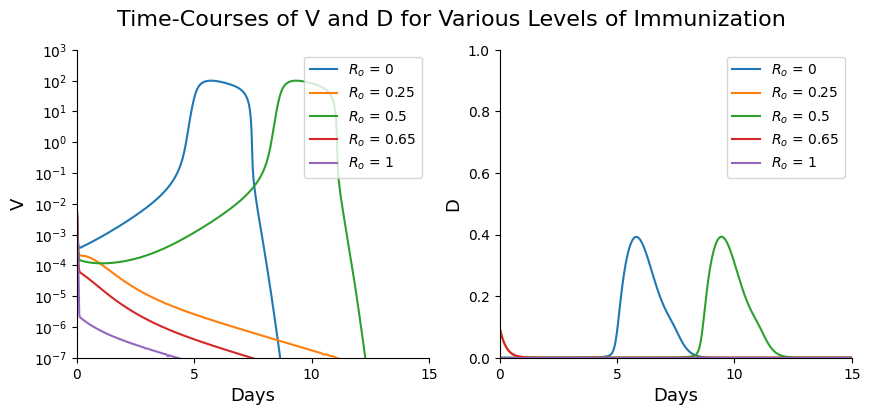

In [79]:
# Figure 6

# Generate time array that contains 1000 equally-spaced values between 0 and 15
t = np.linspace(0, 15, 1000)

R0_lst = [0, 0.25, 0.5, 0.65, 1]
H0_lst = R0_lst[::-1]

# Create empty lists to store results
V_IMM, D_IMM = [], []

for i in range(len(R0_lst)):

    # Define initial values for a system with revised initial states
    V0, H0, I0, M0, F0, R0, E0, P0, A0, S0 = 0.01, H0_lst[i], 0, 0, 0, R0_lst[i], 1, 1, 1, 0.1

    # Define initial state with current viral load value
    state0 = [V0, H0, I0, M0, F0, R0, E0, P0, A0, S0]

    # Solve ODEs using revised initial state and standard parameters
    state = odeint(get_deriv, state0, t, args=(params_std,))

    # Transpose state matrix to get individual time series for each variable
    V, H, I, M, F, R, E, P, A, S = state.T

    # Calculate the results for the proportion of dead cells
    D = 1 - H - R - I

    # Append results to respective lists
    V_IMM.append(V), D_IMM.append(D)

# Initialize y axis labels, title, and subplots
F7_labels = ['V', 'D']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle('Time-Courses of V and D for Various Levels of Immunization', fontsize = 16)

# Set plot parameters and labels for each subplot
for i, ax in enumerate(axes.flat):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if i in range(0, 2):
        xticks = np.arange(0, 16, 5)
        ax.set_xticks(xticks)
        ax.set_xlim(0, 15)
        ax.set_xlabel('Days', fontsize=13)
        ax.set_ylabel(F7_labels[i], fontsize=13)

# Plot time course of V for each gammaHV value
for i in range(len(R0_lst)):  
    axes[0].semilogy(t, V_IMM[i], label=r'$R_o$ = {}'.format(R0_lst[i]))
yticks = [10**i for i in range(-7, 4)]
axes[0].set_ylim([yticks[0], yticks[-1]])
axes[0].set_yticks(yticks)
axes[0].legend(loc = 'upper right')

# Plot time course of D for each gammaHV value
for i in range(len(R0_lst)):
    axes[1].plot(t, D_IMM[i], label=r'$R_o$ = {}'.format(R0_lst[i]))
axes[1].set_ylim(0, 1.0)
axes[1].legend()

# Save figure and show time courses
plt.savefig('figure6', dpi = 300)
plt.show()



TypeError: 'module' object is not callable

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional